# 0.0 IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime

import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
     %matplotlib inline
     %pylab inline
     plt.style.use( 'bmh' )
     plt.rcParams['figure.figsize'] = [25, 18]
     plt.rcParams['font.size'] = 32
     display( HTML( '<style>.container { width:100% !important; }</style>') )
     pd.options.display.max_columns = None
     pd.options.display.max_rows = None
     pd.set_option( 'display.expand_frame_repr', False )
     sns.set()
 

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False )
df_store_raw = pd.read_csv('data/store.csv', low_memory=False )

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
18696,857,3,2015-07-15,8834,975,1,1,0,0,c,a,6270.0,8.0,2005.0,1,23.0,2014.0,"Mar,Jun,Sept,Dec"


# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list( map( snakecase, cols_old ))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}' .format(df1.shape[0]))
print( 'Number of Columns: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types 

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical 

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [16]:
# Central Tendence - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attribuites', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attribuites,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:xlabel='assortment', ylabel='sales'>

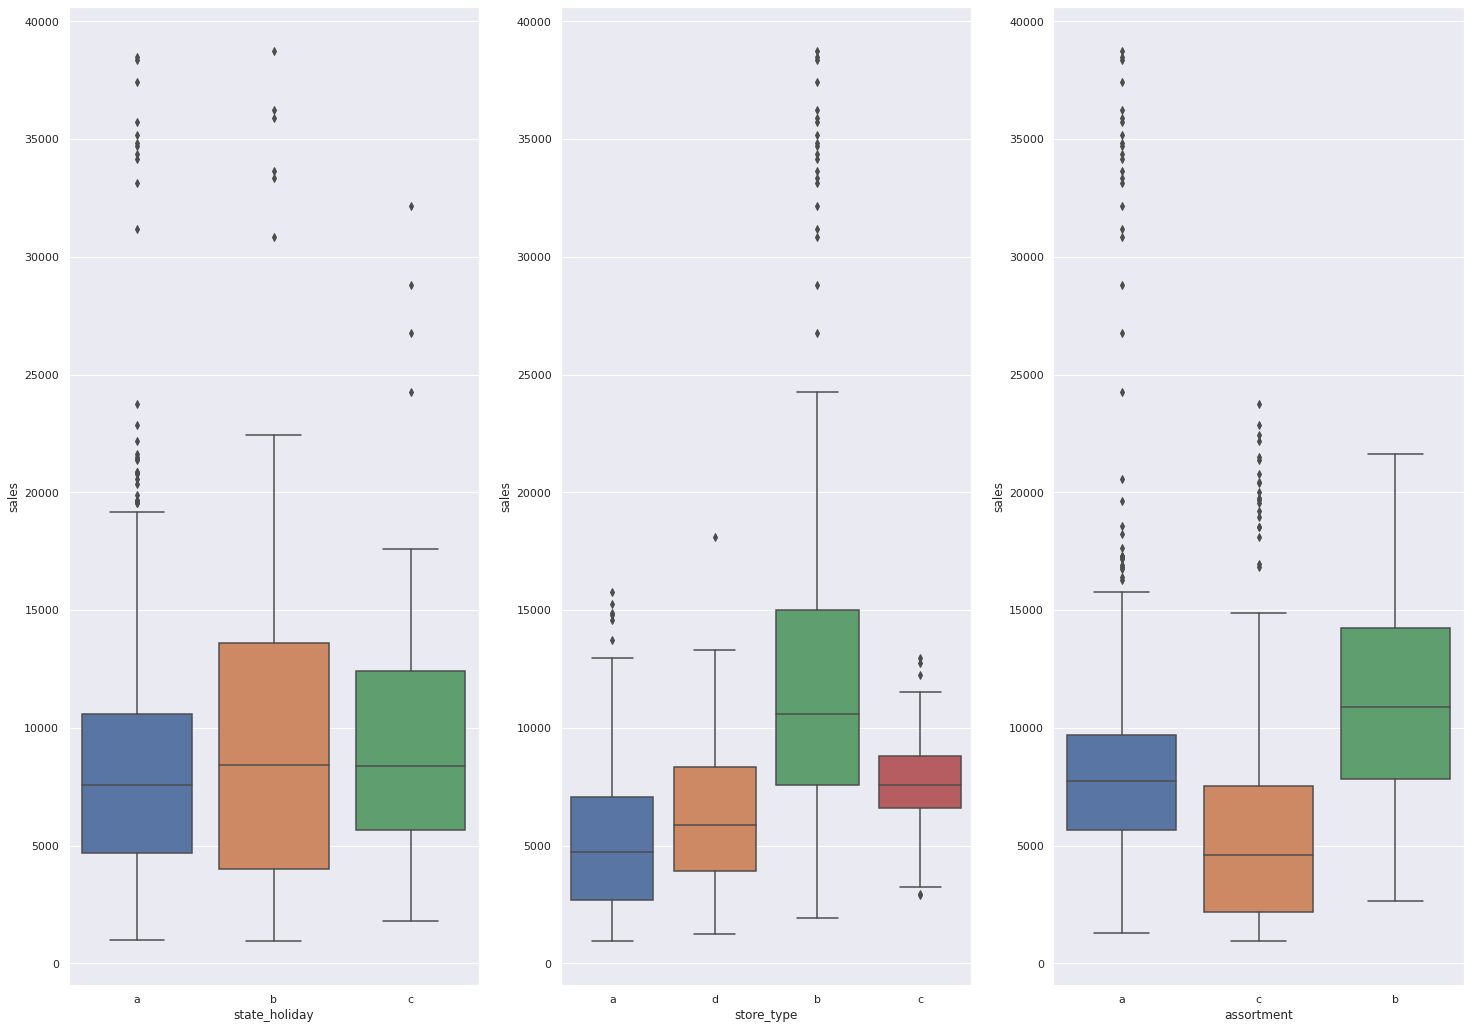

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#fig = plt.figure(figsize=(18,8), facecolor='#D1D1D1')
jupyter_settings()

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

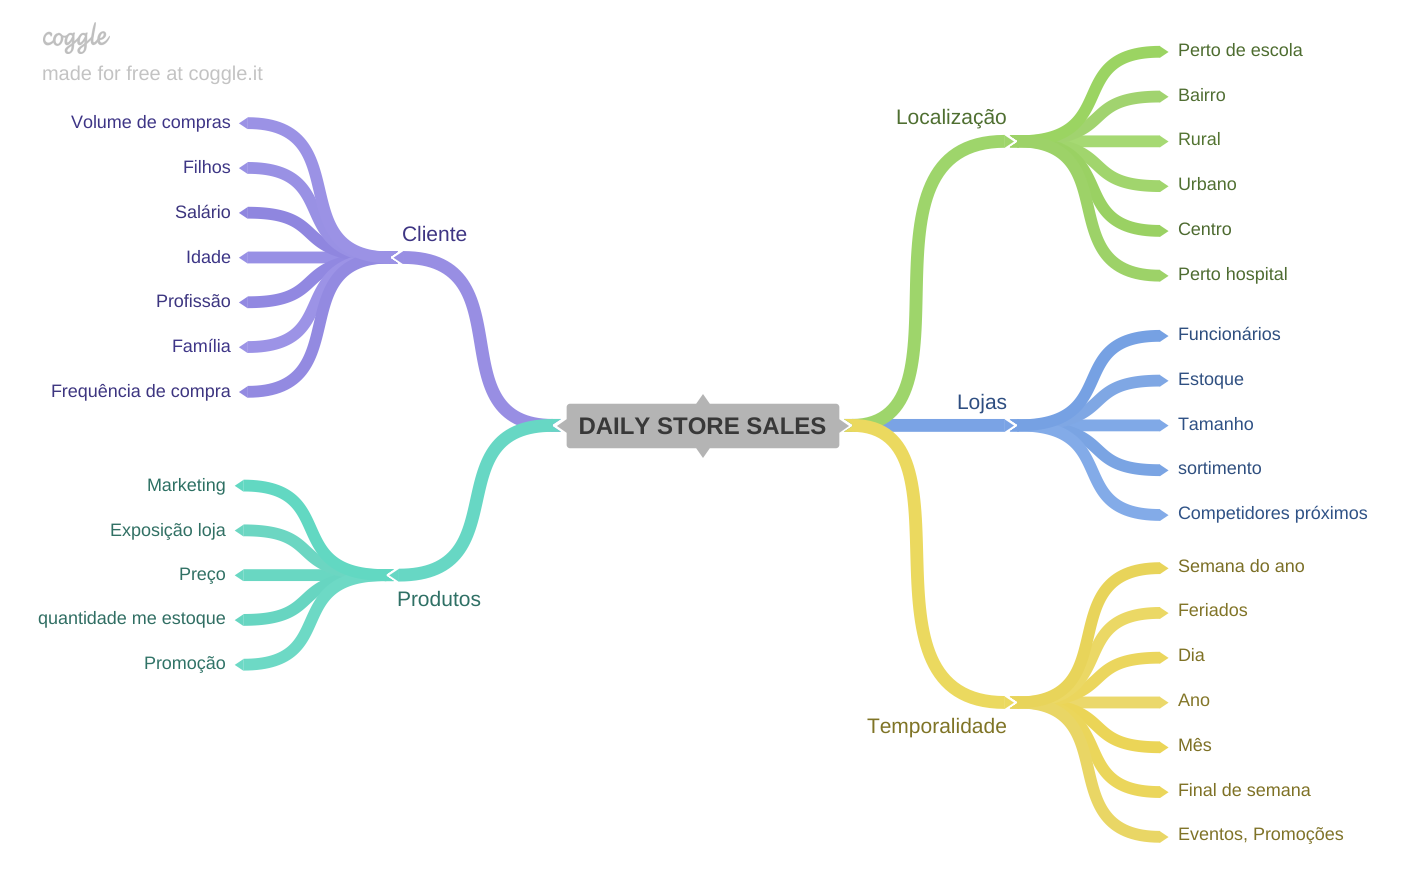

In [20]:
Image('img/MindMapHypothesis.png')

## 2.2. Criação de Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento de produto deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produtos

**1.** Lojas que investem mais em margeting deveriam vender mais.

**2.** Lojas com maior exposição do produto deveriam vender mais.

**3.** Lojas com produtos de menor preço deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Temporais

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista final de hipóteses

**1.** Lojas com maior sortimento de produto deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply (lambda x: datetime.datetime (year = x['competition_open_since_year'], month = x['competition_open_since_month'] , day = 1), axis = 1)
df2['competition_time'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [23]:
df3 = df2.copy()

In [24]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas

In [25]:
# Para haver vendas a loja precisa estar aberta
# Só interessam as vendas maiores que 0, quando for 0 a loja estava fechada
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [26]:
# CUSTOMERS - Não há como saber quantos consumidores estarão na loja nos dias das 6 semanas de predição de vendas
# OPEN - Após a filtragem das linhas feita acima, a coluna open passou a ter apenas valores 1, assim não há variação e informação relevante.
# PROMO_INTERVAL - Foi derivada e resultou a coluna IS_PROMO, seu conteúdo não é mais relevante.
# MONTH_MAP - coluna auxiliar usada para a criação das datas, neste momento já não tem mais utilidade.

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [28]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

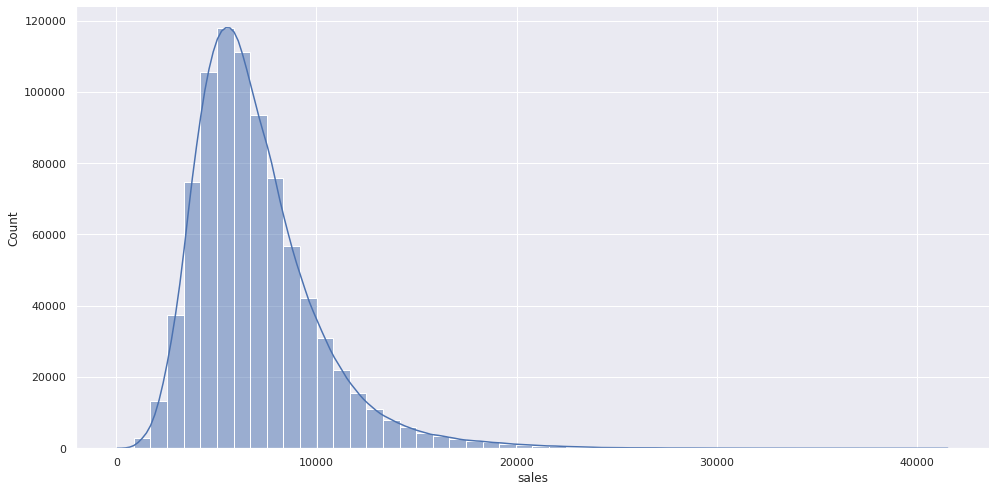

In [29]:
sns.displot(df4['sales'], kind='hist', height=7, aspect=2, bins=50, kde=True)

### 4.1.2. Numerical Variable

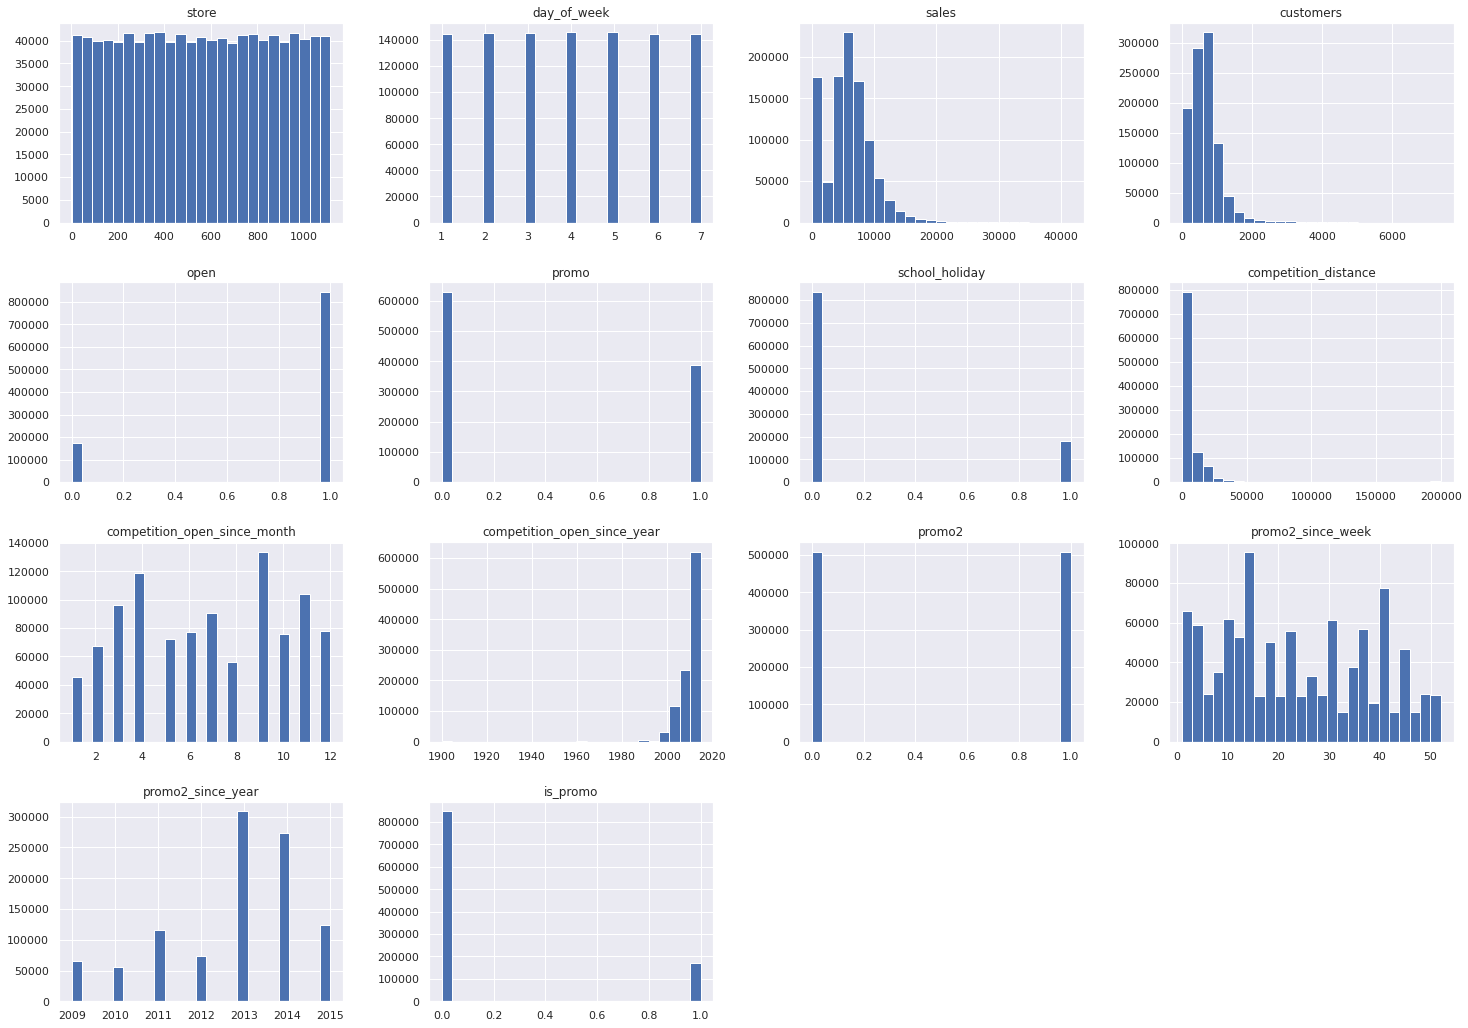

In [30]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/eron/.pyenv/versions/3.9.4/envs/RossmannProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

<AxesSubplot:xlabel='sales', ylabel='Density'>

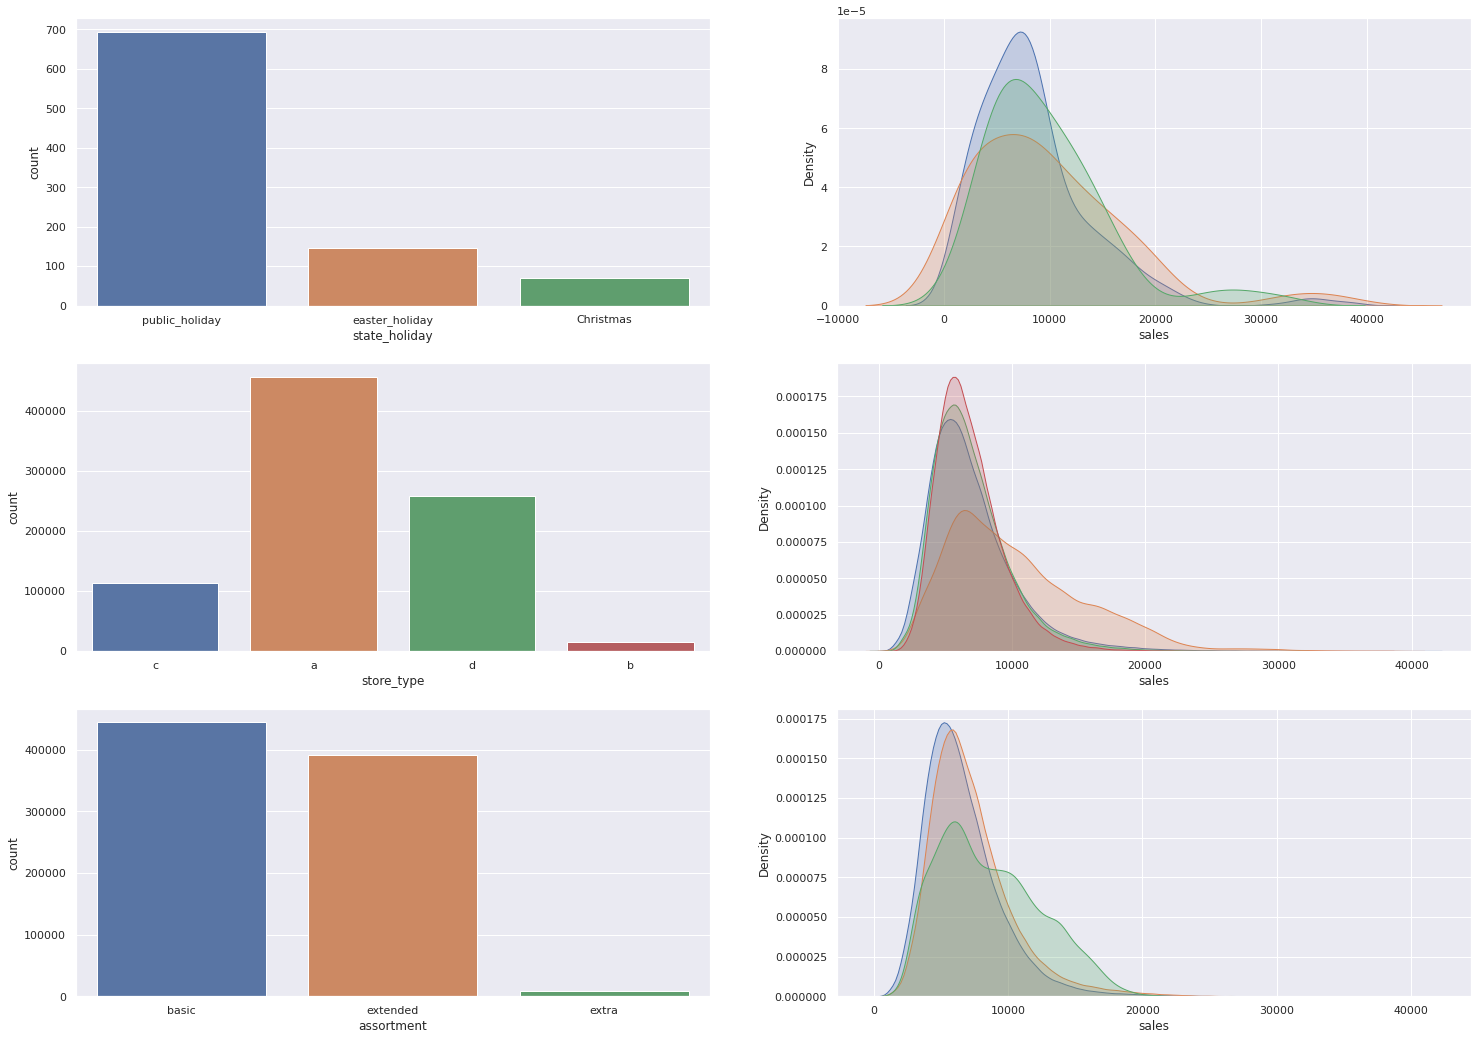

In [31]:
# state_holiday
plt.subplot (3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot (3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade = True)

# store_type
plt.subplot (3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot (3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade = True)

# assortment
plt.subplot (3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot (3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade = True)

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimento de produto deveriam vender mais.

**FALSA** - Loja com **MAIOR SORTIMENTO** (assortment) vendem **MENOS**

<AxesSubplot:xlabel='year_week'>

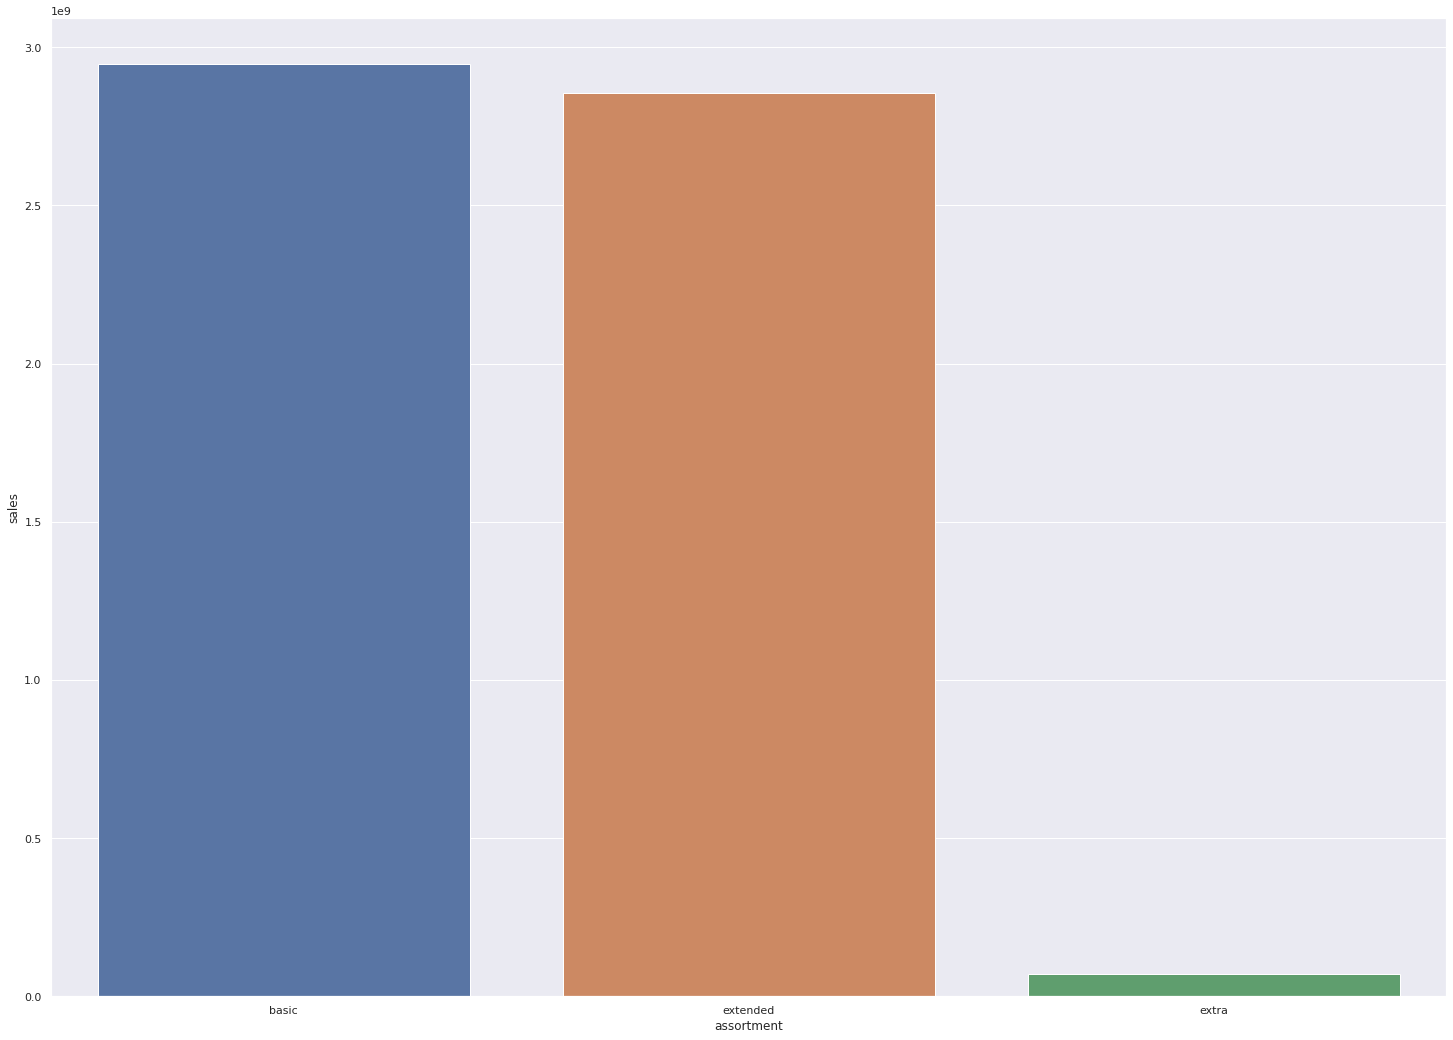

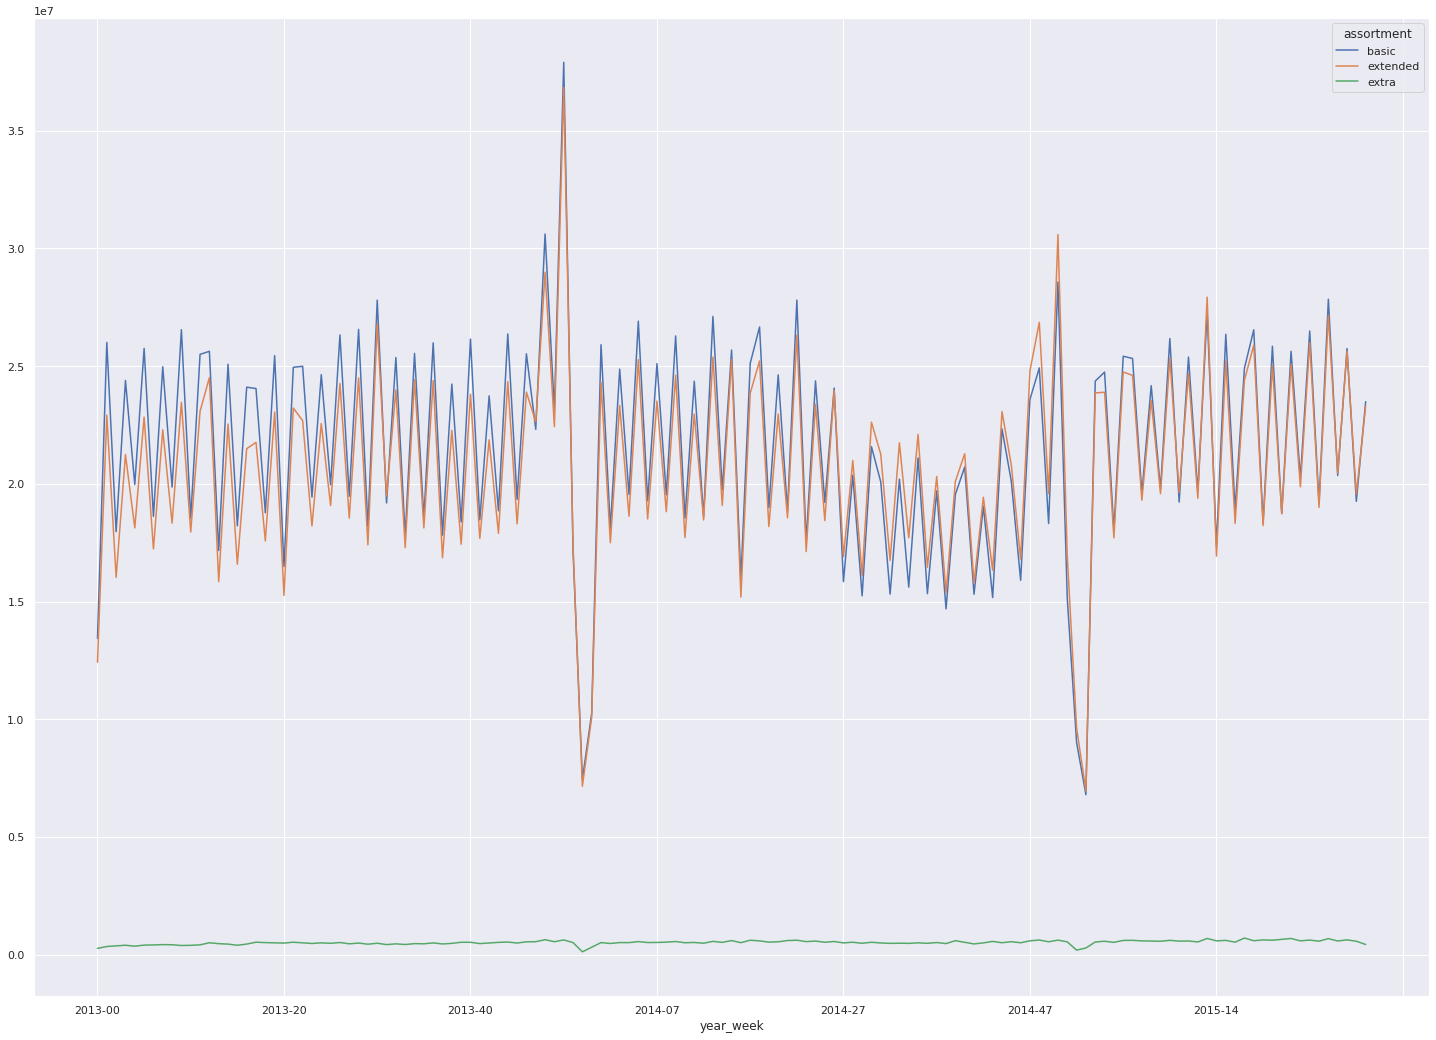

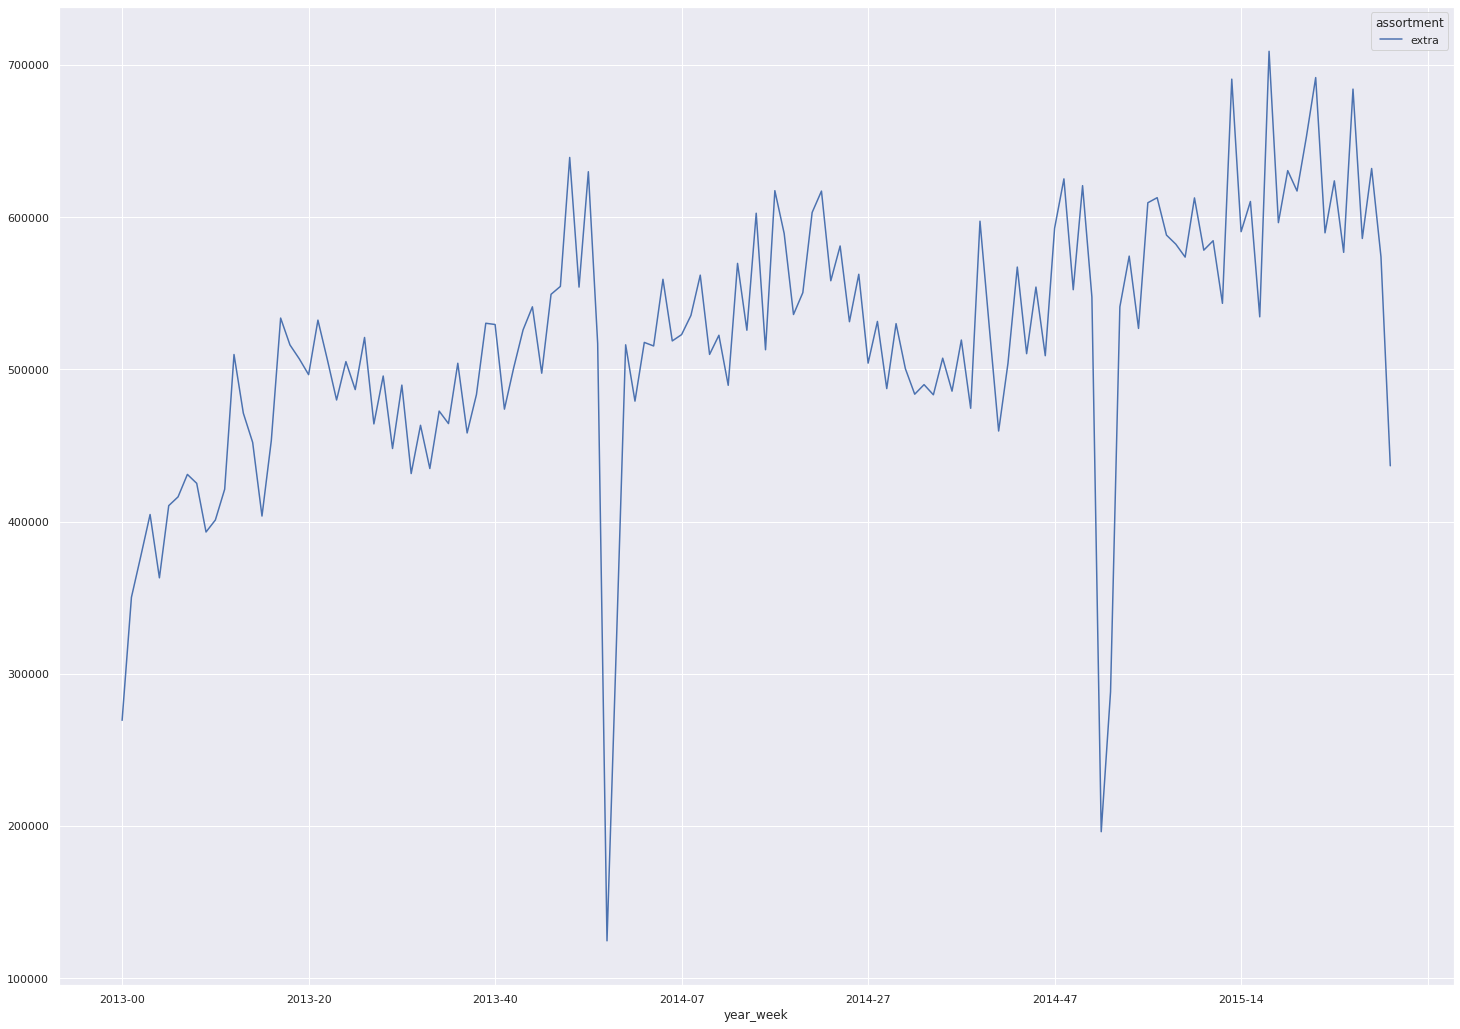

In [32]:
# Relação das vendas em função do mix de produtos (sortimento)

# Seleciona as colunas assortment e sales, agrupa pelo tipo de assortment e soma as vendas de cada grupo e reseta
# o index para obter um DataFrame, atribui o resultado a variável aux1.
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

# Plota a relação entre as colunas
sns.barplot( x = 'assortment', y = 'sales', data = aux1);

# Segundo o gráfico, lojas com o assortment EXTRA são as que possuem menor volume de vendas

# Inclui na avaliação as vendas semanais, para verificar se houve uma mudança de tendência em algum momento, que 
# indique o pq do assortment EXTRA ter poucas vendas. 
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

# Para obter um gráfico com melhor informação, devemos inverter as linhas e colunas. .plot ao final gera o gráfico
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

# Avaliação do EXTRA de forma mais detalhada

# Extrai do AUX2 apenas os dados do assortment EXTRA e salva em AUX3
aux3 = aux2[aux2['assortment'] == 'extra']

# Realiza o pivot para inverter as linhas e colunas e plota o gráfico
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** - Lojas com **COMPETIDORES MAIS PRÓXIMOS** vendem **MAIS** 


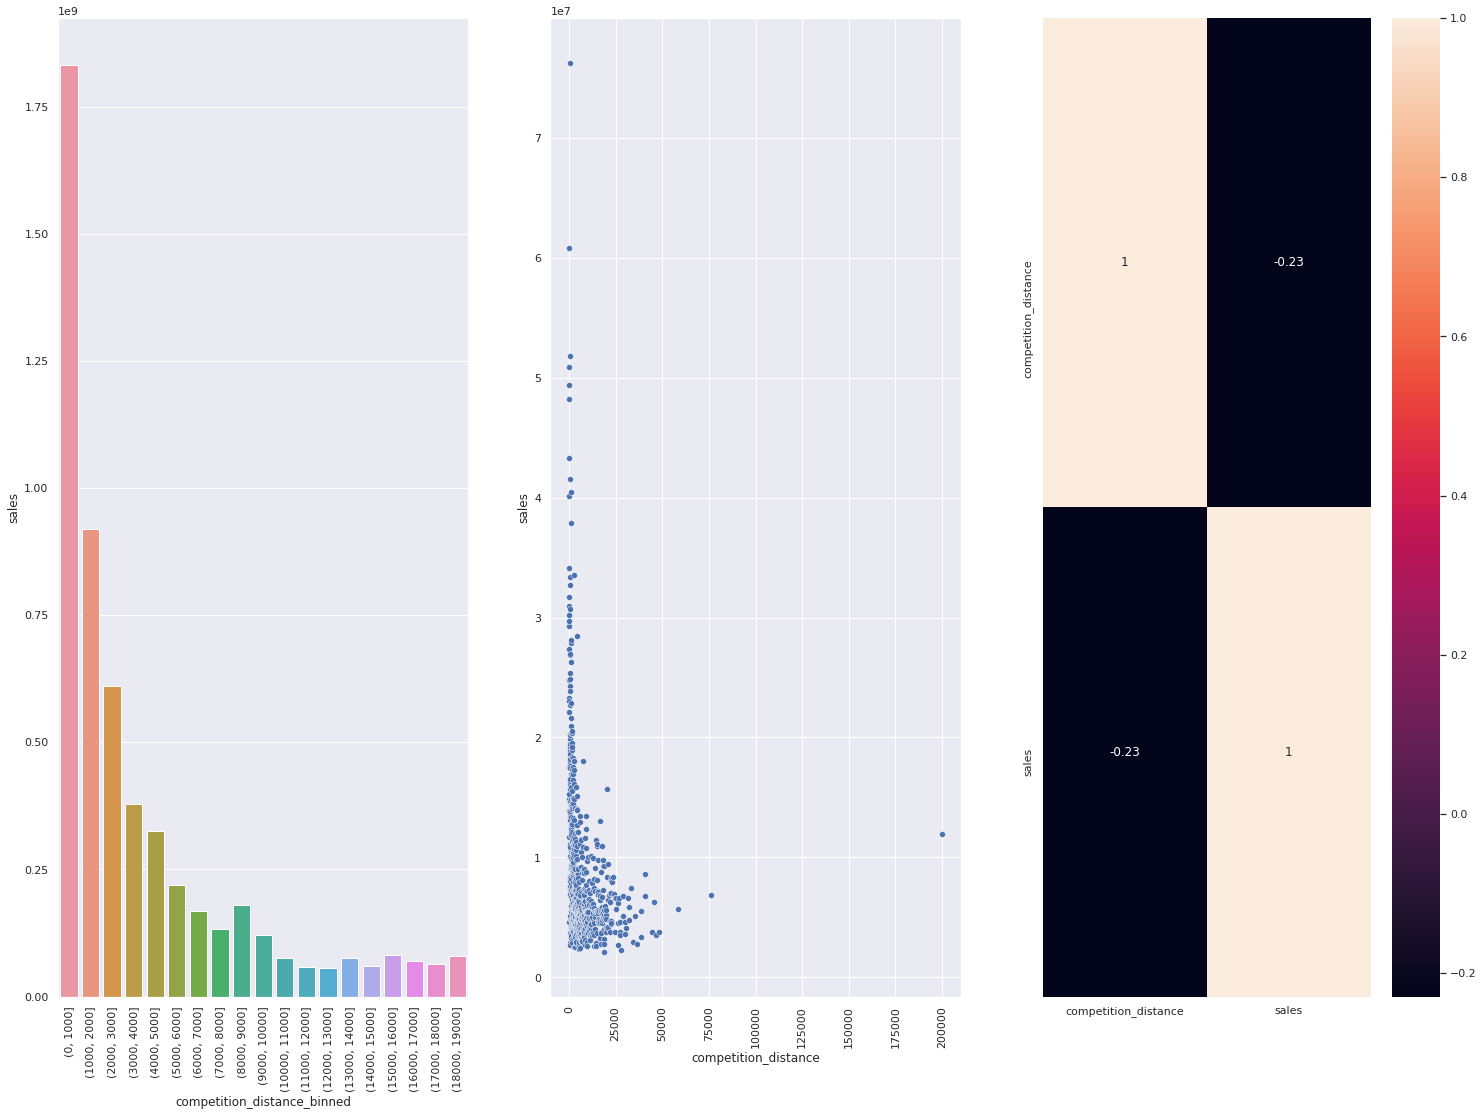

In [33]:
# Relação das vendas em função distância dos competidores

# Seleciona as 'competition_distance' e 'sales', agrupa pelo distância dos competidores, 
# soma as vendas de cada grupo e reseta o index para obter um DataFrame, atribui o resultado a variável aux1.
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# O resultado acima vai trazer um grupo de dados com granularidade muito alta, uma vez que a distância 
# do competidor pode variar muito.
# A solução é agrupar as distâncias e analisar as vendas em função desses grupos de distância.
# Assim, cria-se uma variável que vai armazenar esse agrupamento chamada BINS
# Cria-se uma lista, onde o np.arrange vai criar faixas de valores começando em 0, indo até 20000, em intervalos
# de 1000 em 1000.
bins = list(np.arange(0, 20000, 1000))

# Após, cria-se uma nova coluna no DF onde serão definidos em qual intervalo cada linha está.
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

# Realiza o agrupamento das vendas pelas faixas de disTância criadas e soma dentro de cada grupo
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Plota o resultado com gráfico de barras
plt.subplot (1, 3, 1)
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks (rotation = 90);

# Plota o resultado com scatter para visualizar melhor a concentração dos doados. Usa o AUX1 e 
# competition_distance, pois aqui é melhor que os valores mantenham a granularidade.
plt.subplot (1, 3, 2)
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1);
plt.xticks (rotation = 90);


# Este gráfico mede a corelação entre as variáveis, a escala varia de 0 até 1, quanto mais perto de 0 mais fraca
# será a corelação entre as variáveis. Um resultado de 0.23 é considerado bom.
plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);




### H3. Lojas com competidores há mais tempo deveriam vender mais.
**FALSA** - Lojas com **COMPETIDORES HÁ MAIS TEMPO** vendem **MENOS**

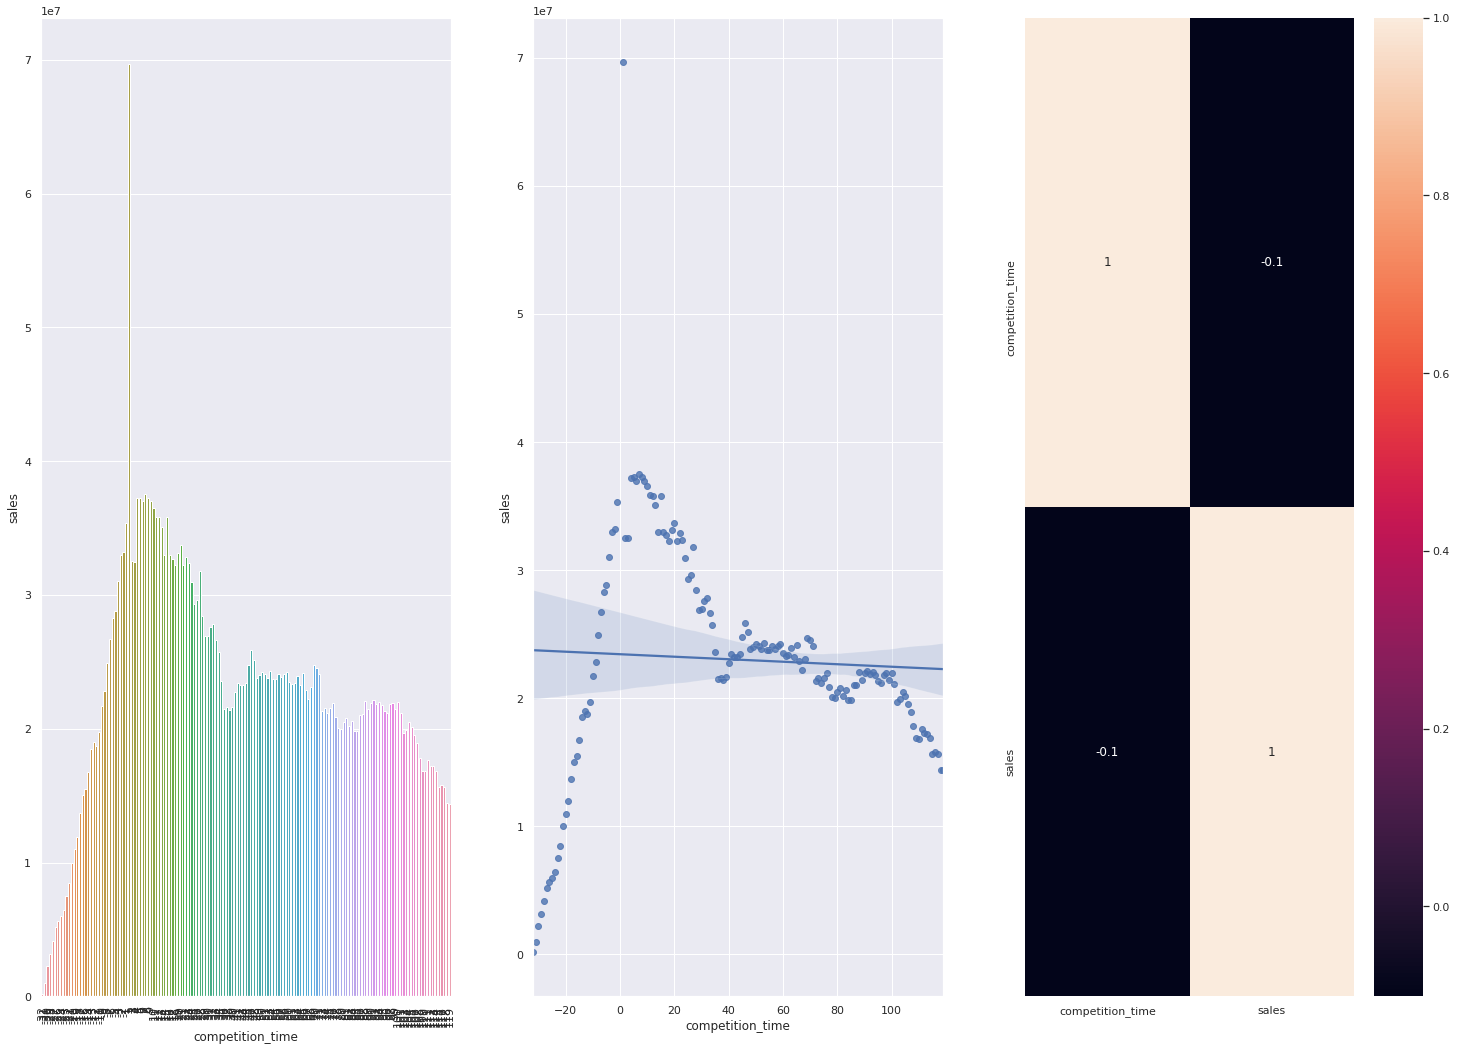

In [34]:
# Relacionar o tempo de abertura da concorrência com o nível de vendas das lojas

aux1 = df4[['competition_time', 'sales']].groupby('competition_time').sum().reset_index()

# O resultado da seleção acima traz uma granularidade muito grande, então é preciso aplicar um filtro para 
# diminuir o número de resultados e ficar possível visulaizar as variações
aux2 = aux1[(aux1['competition_time'] < 120) & (aux1['competition_time'] != 0)]

plt.subplot (1, 3, 1)
sns.barplot (x = 'competition_time' , y = 'sales', data = aux2);
plt.xticks(rotation = 90);
# O gráfico mostra que a proximidade da data de abertura da competição estimula as vendas.

# Gráfico que indica a tendência de vendas nesta situação
plt.subplot (1, 3, 2)
sns.regplot (x = 'competition_time' , y = 'sales', data = aux2);

# Corelação entra as variáveis, 0.1 ainda é considerado bom
plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos, pois com o passar do tempo as vendas caem novamante.

<AxesSubplot:>

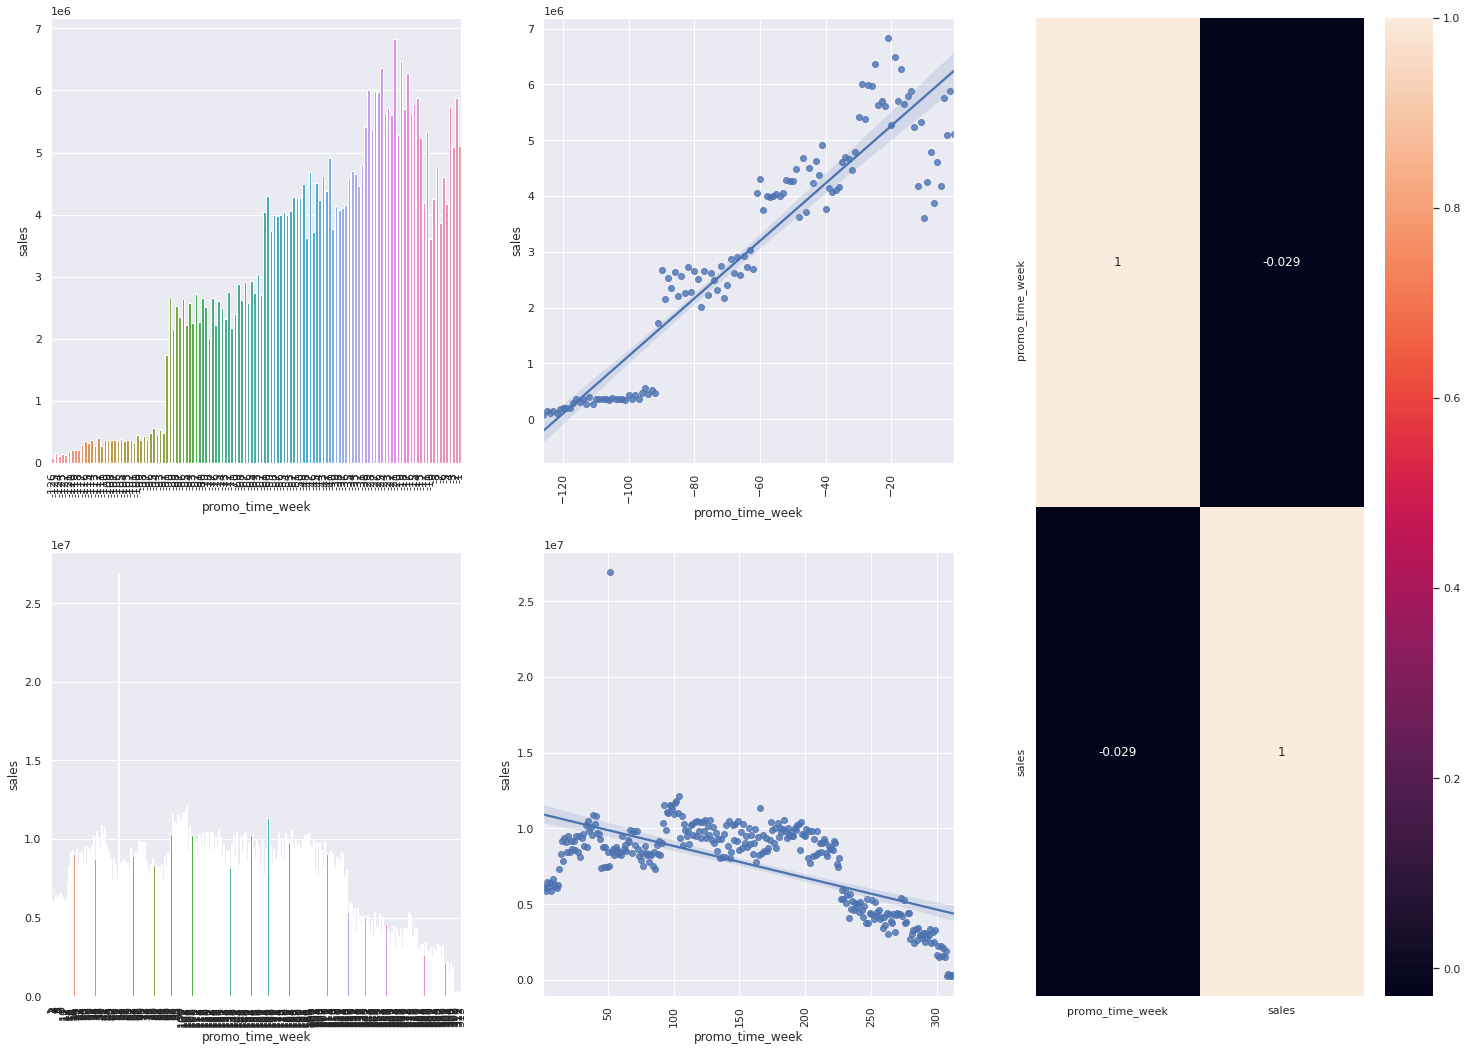

In [40]:
# Seleciona as colunas PROMO_TIME_WEEK e SALES, agrupa pelo PROMO_TIME_WEEK, 
# soma as vendas dentro dos agrupamentos e reseta o index para melhorar a visualização.
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# O gráfico resultante dos dados acima possuem uma granularidade muito grande e, por consequencia, é impossível fazer uma análise adequada,
# assim, é preciso fazer um recorte nestes dados através de filtragem.
# O resultado negativo (PROMO_TIME_WEEK < 0) significa que a venda foi feita no período de promoção normal e antes do início da promoção extendida, 
# o valor positivo (PROMO_TIME_WEEK > 0) informa que a venda ocorreu durante a promoção extendida.

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção regular
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3);
plt.xticks (rotation = 90);

plt.subplot(grid[0, 1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux3);
plt.xticks (rotation = 90);

plt.subplot(grid[1, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção extendida
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2);
plt.xticks (rotation = 90);

plt.subplot(grid[1, 1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux2);
plt.xticks (rotation = 90);

#Força da corelação
plt.subplot(grid[:, 2])
sns.heatmap( aux1.corr( method= 'pearson'), annot=True);
# A corelação de 0.029 é fraca, provavelament não entrará no modelo.

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>

**FALTAM DADOS - Validar no próximo ciclo**

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** - Lojas com mais promoções consecutivas vendem menos

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


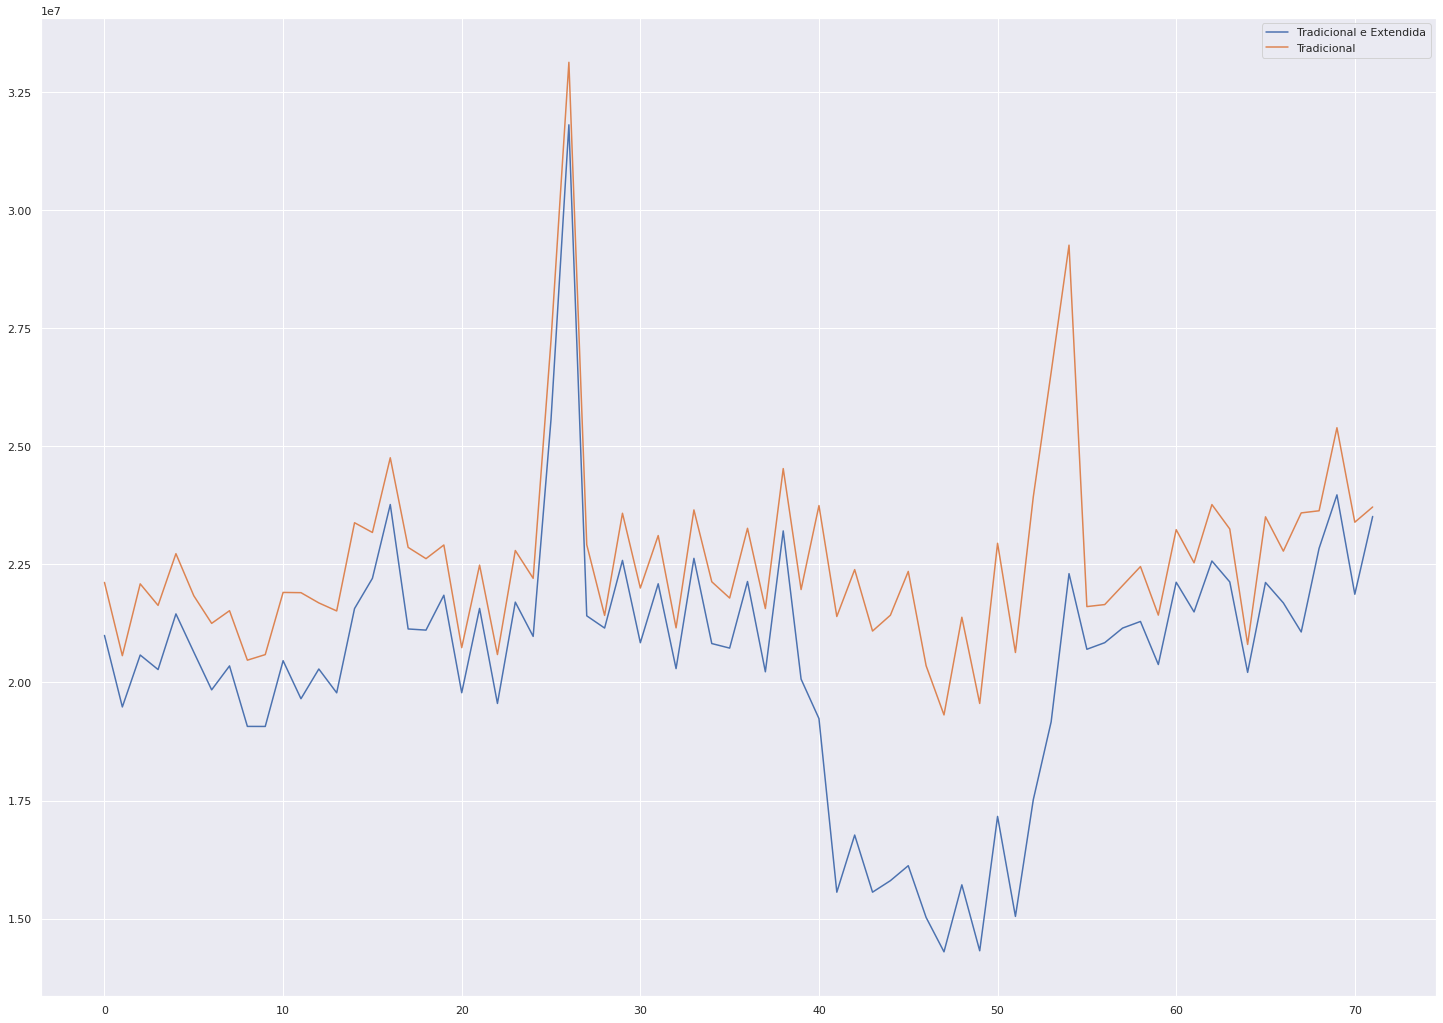

In [52]:
# Seleciona as lojas que participaram dos DOIS PERÍODOS de promoção, agrupa pelas vendas no período
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# Seleciona as lojas que participaram APENAS DO PERÍODO TRADICIONAL de promoção, agrupa pelas vendas no período
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax);
ax.legend( labels = ['Tradicional e Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado de natal vendem menos

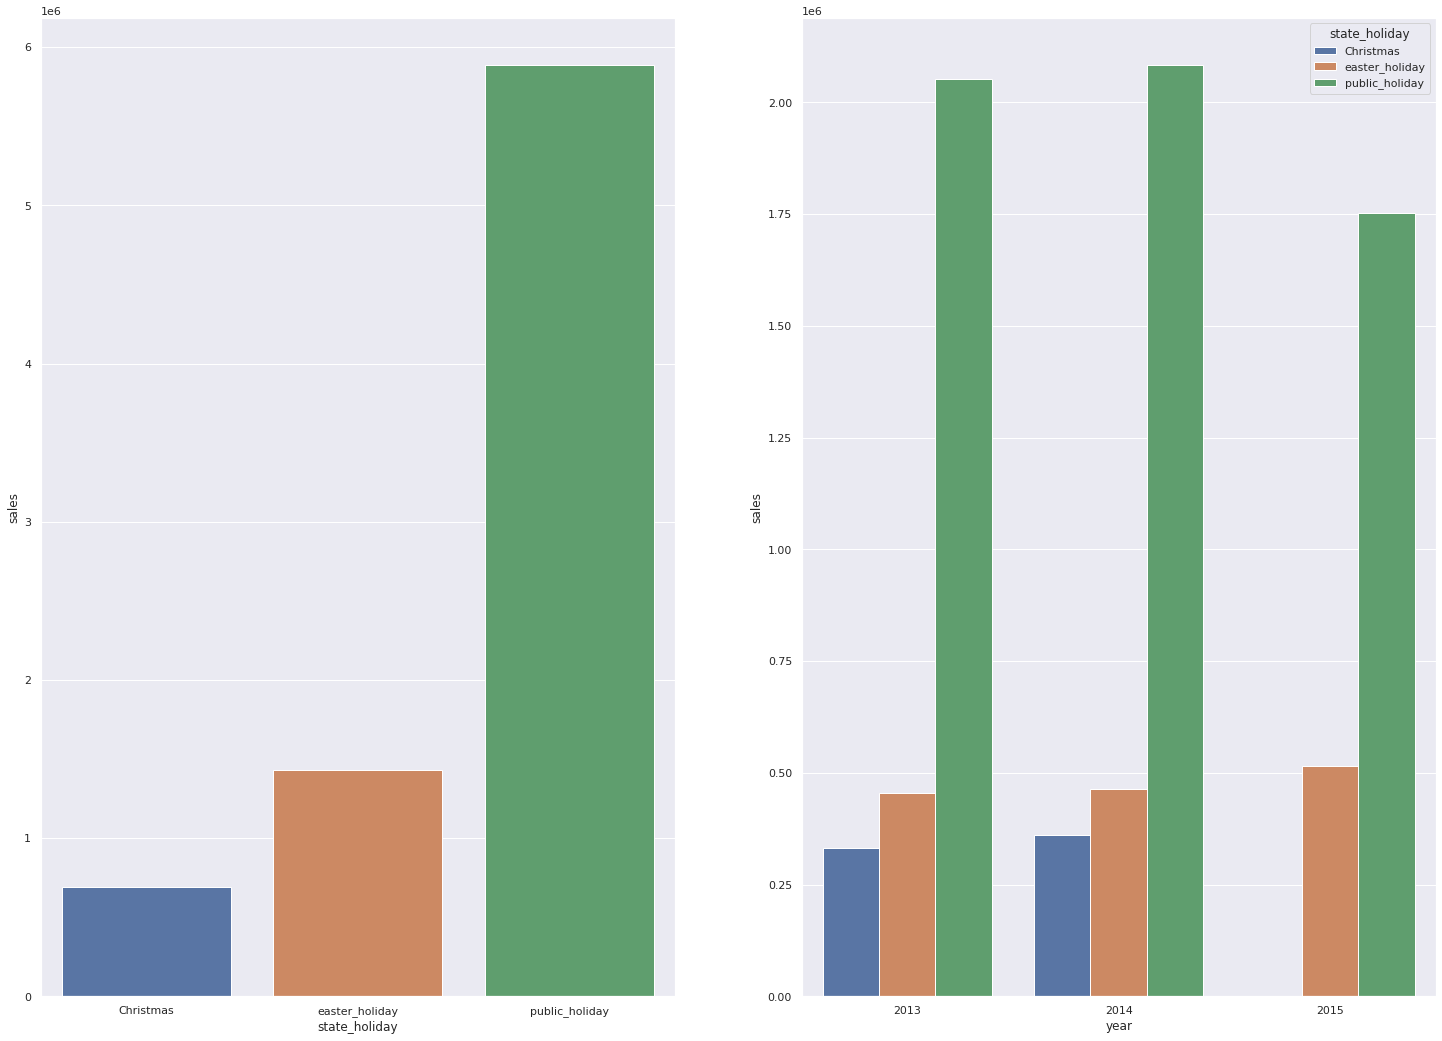

In [61]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.subplot (1, 2, 1)
sns.barplot(x= 'state_holiday', y= 'sales', data= aux1);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

plt.subplot (1, 2, 2)
sns.barplot(x= 'year', y= 'sales', hue= 'state_holiday', data= aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** - As lojas estão vendendo menos ao longo dos anos.

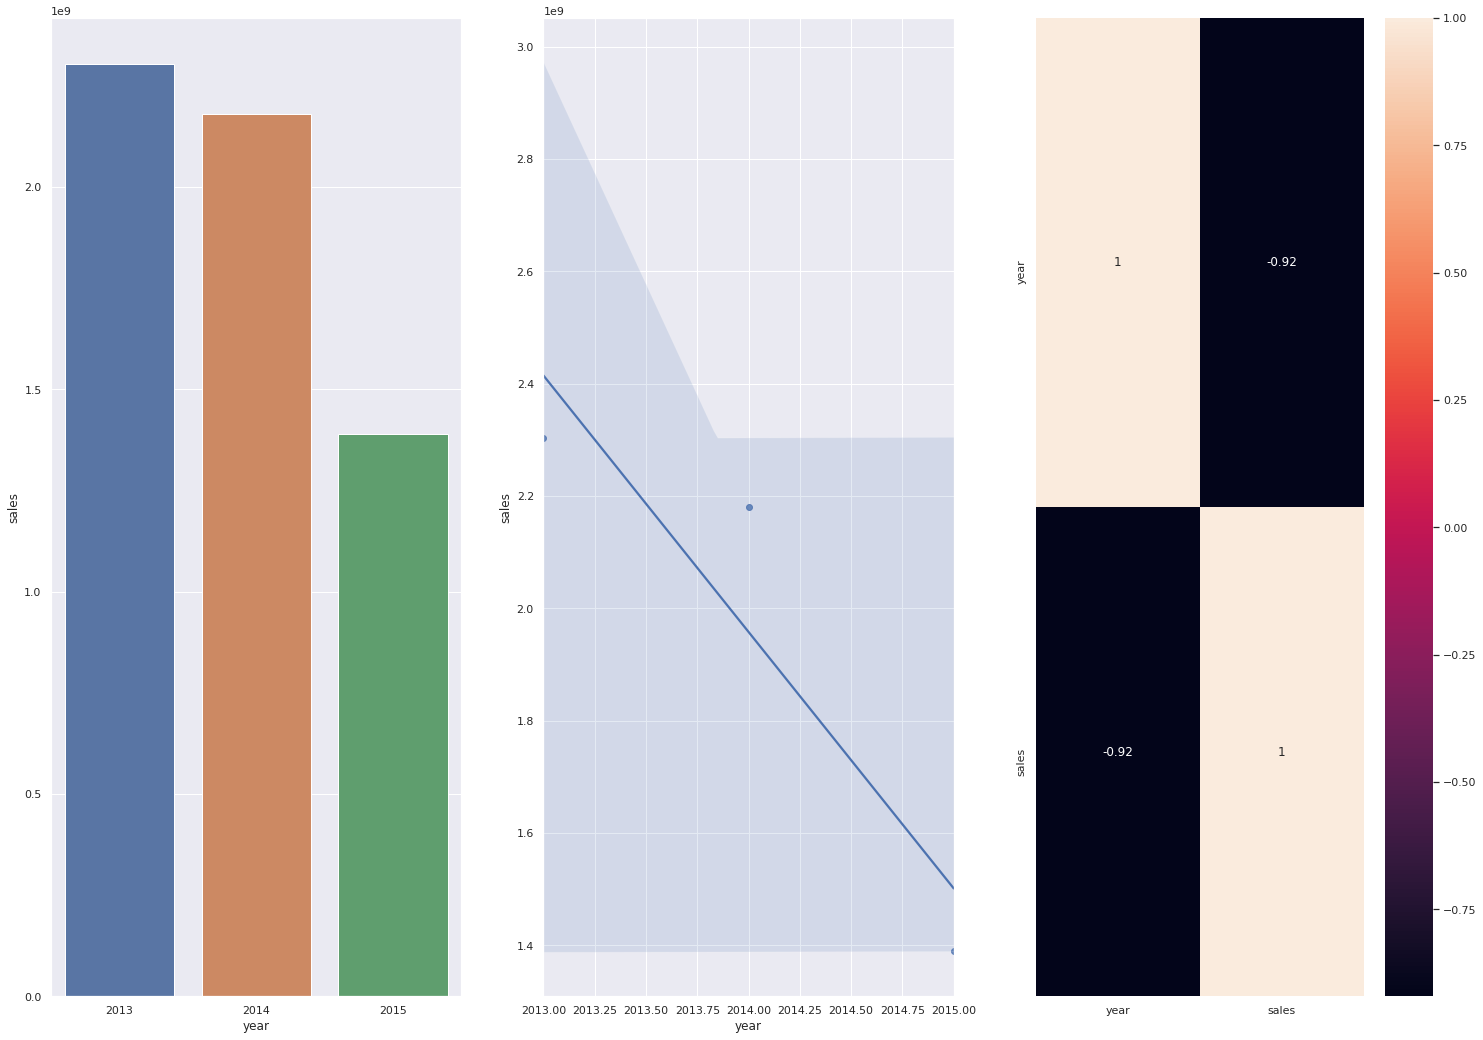

In [63]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()


plt.subplot (1, 3, 1)
sns.barplot(x= 'year', y= 'sales', data= aux1);

plt.subplot (1, 3, 2)
sns.regplot(x= 'year', y= 'sales', data= aux1);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - As lojas vendem menos do segundo semestre de cada ano

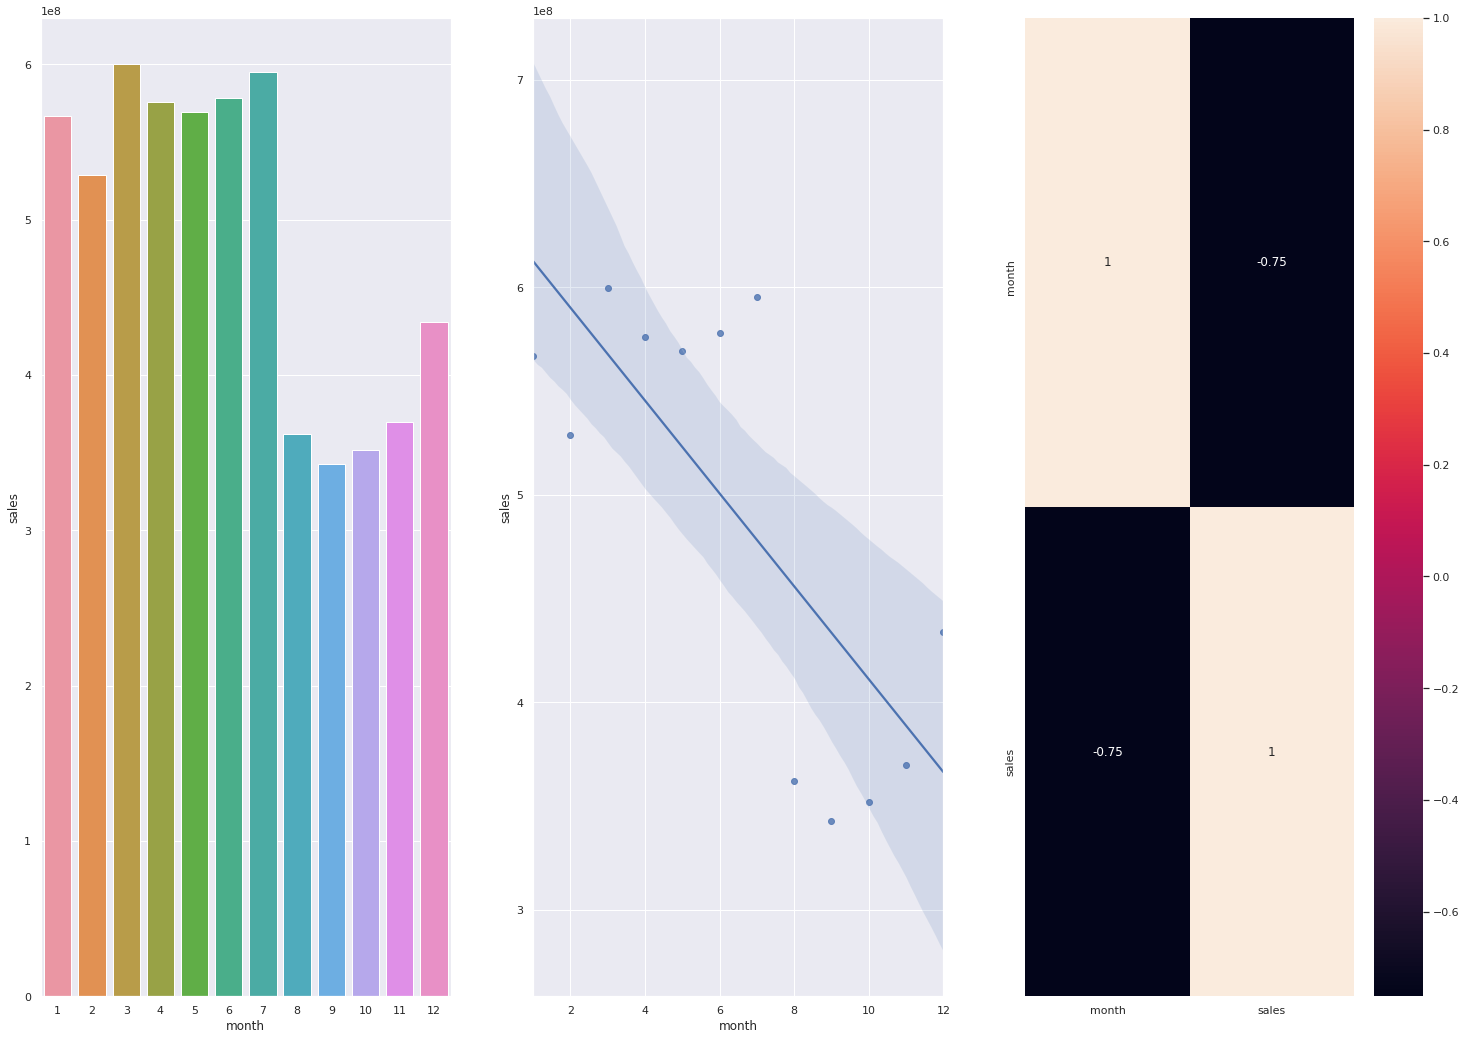

In [64]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()


plt.subplot (1, 3, 1)
sns.barplot(x= 'month', y= 'sales', data= aux1);

plt.subplot (1, 3, 2)
sns.regplot(x= 'month', y= 'sales', data= aux1);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);


### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - As lojas tem uma venda acumulada maior no período após o dia 10.

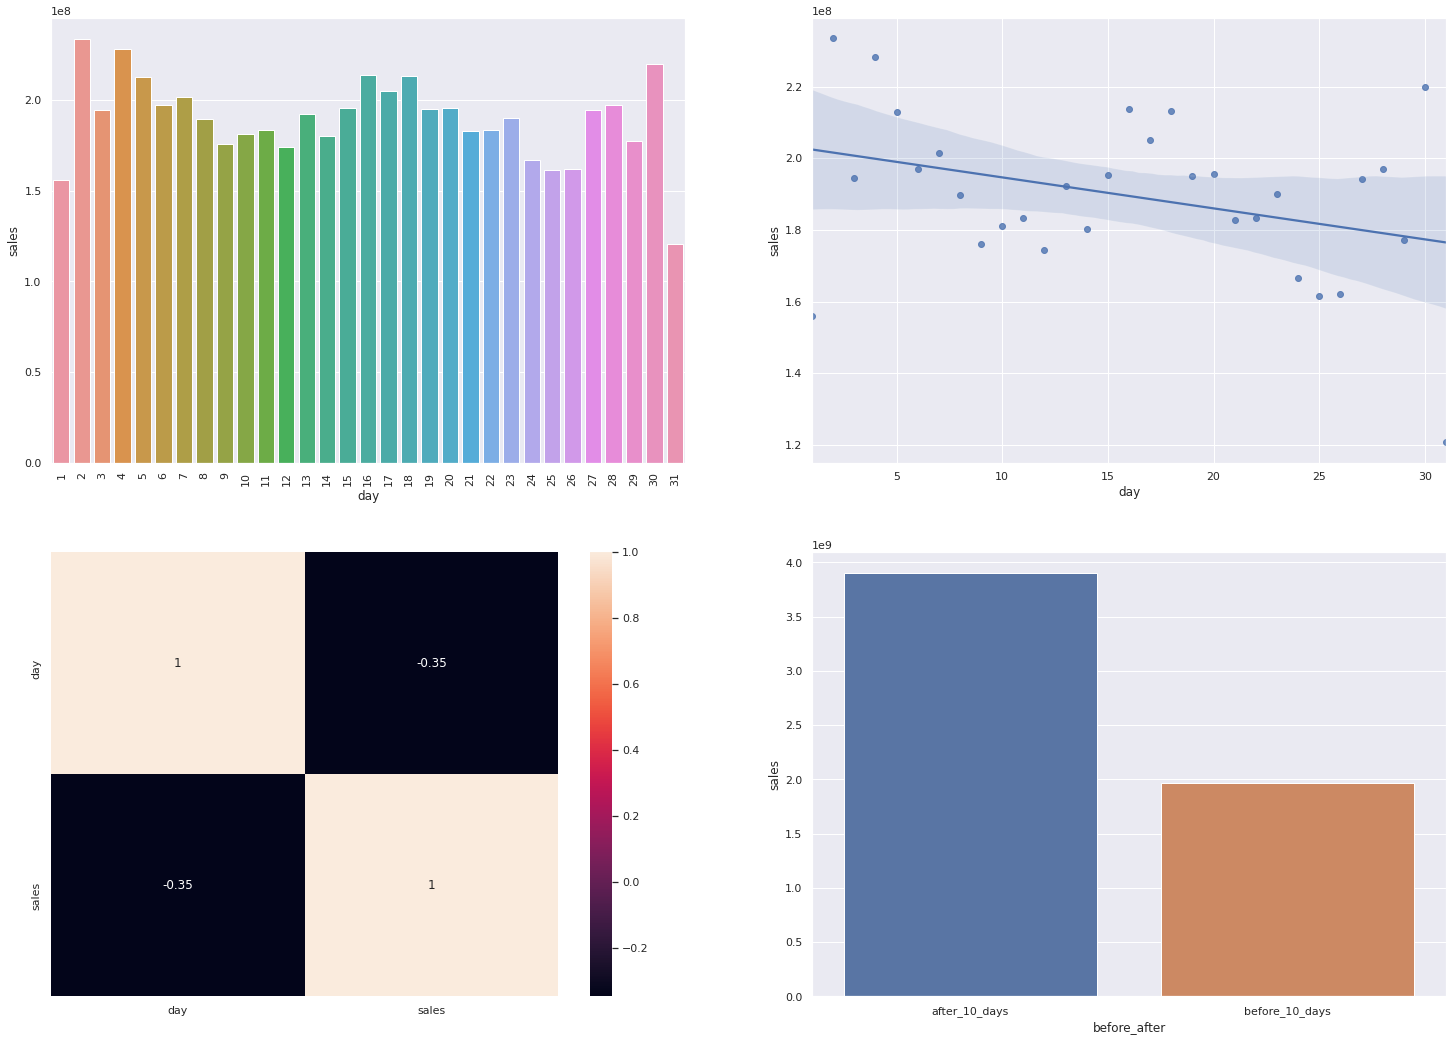

In [68]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot (2, 2, 1)
sns.barplot(x= 'day', y= 'sales', data= aux1);
plt.xticks (rotation = 90);

plt.subplot (2, 2, 2)
sns.regplot(x= 'day', y= 'sales', data= aux1);

plt.subplot (2, 2, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply (lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot (2, 2, 4)
sns.barplot(x= 'before_after', y= 'sales', data= aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** - As lojam vendem menos nos finais de semana.

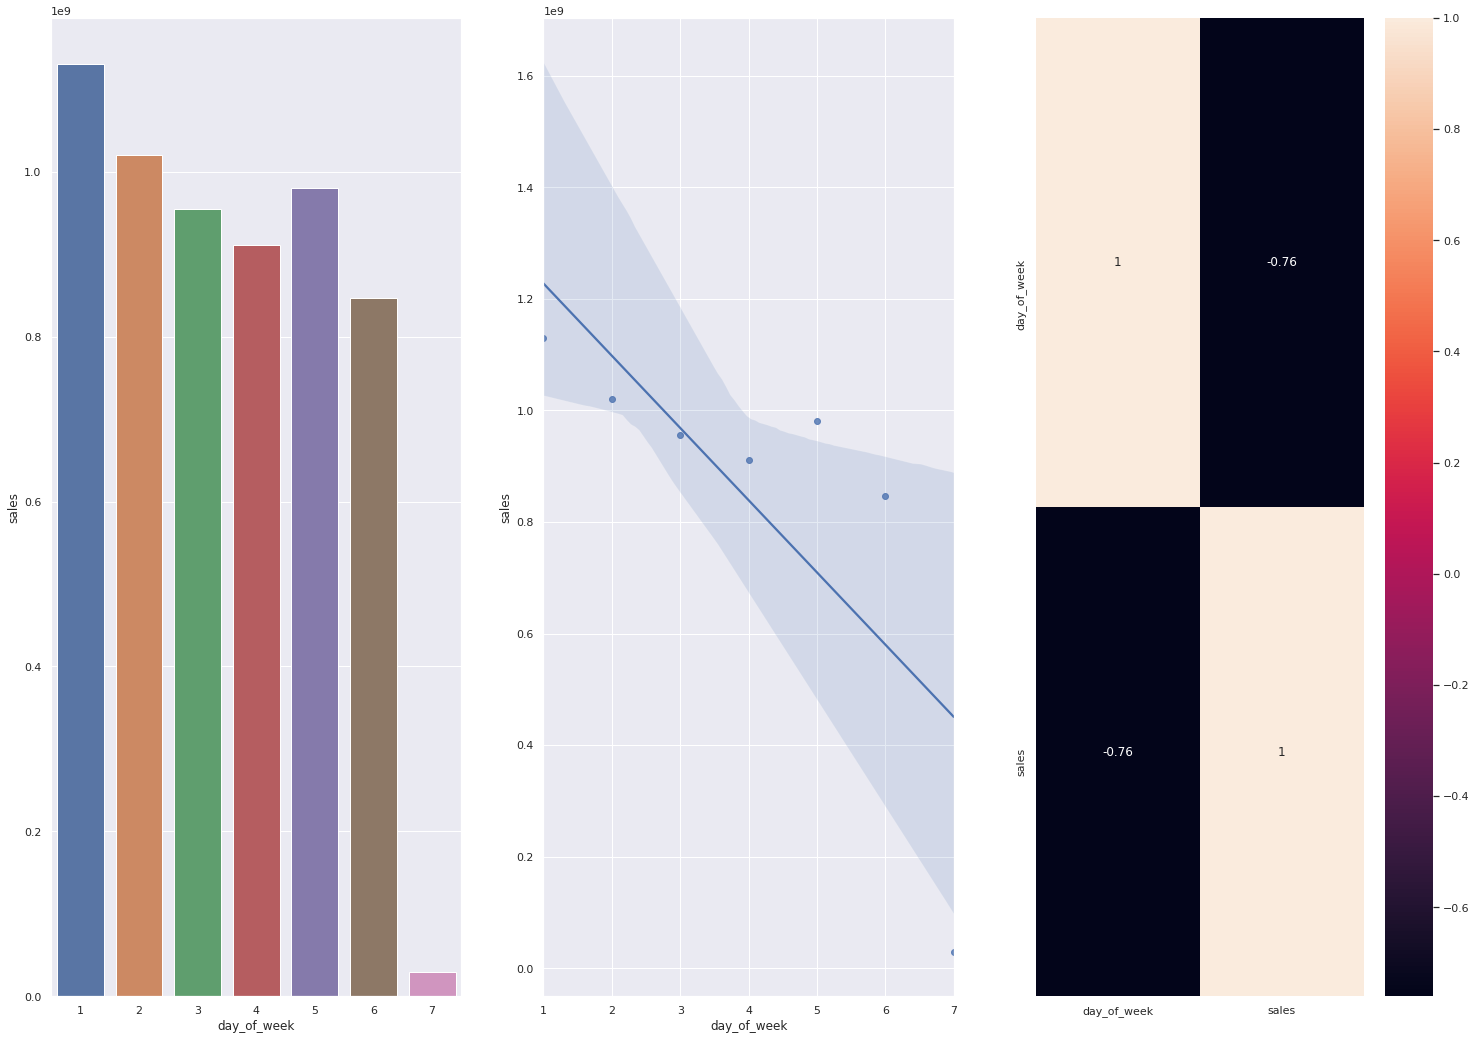

In [69]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot (1, 3, 1)
sns.barplot(x= 'day_of_week', y= 'sales', data= aux1);

plt.subplot (1, 3, 2)
sns.regplot(x= 'day_of_week', y= 'sales', data= aux1);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** - As lojas vendem menos durante os feriados escolares, exceto no período de férias (Jul e Ago)

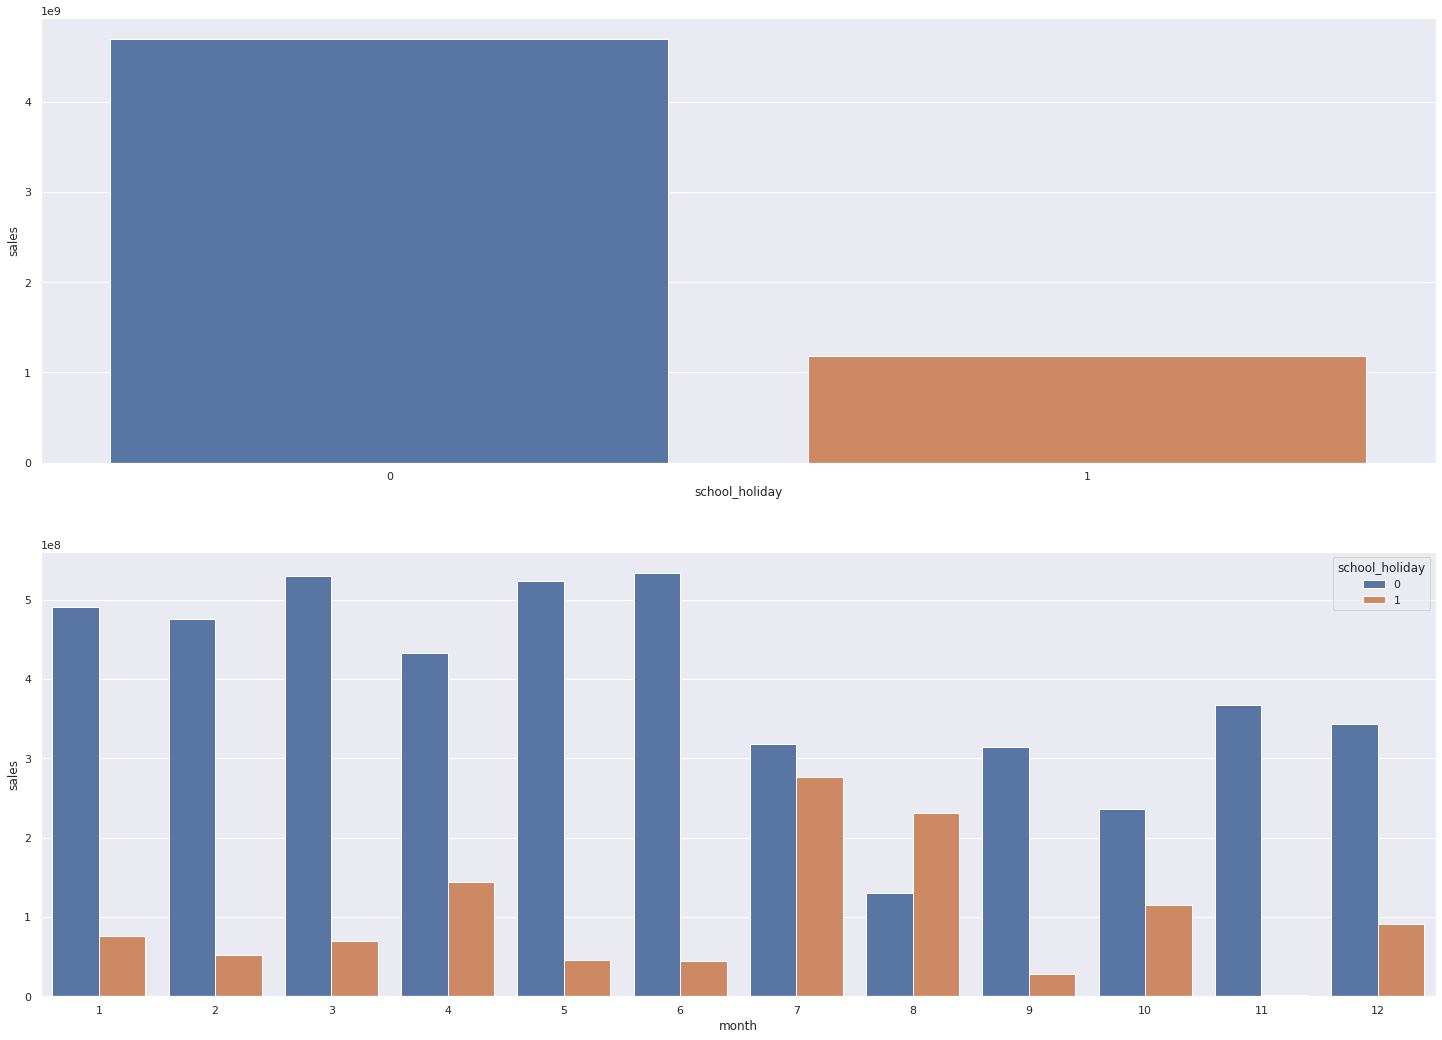

In [75]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x= 'school_holiday', y= 'sales', data= aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x= 'month', y= 'sales', hue= 'school_holiday', data= aux2);


## 4.3. Análise Multivariada